In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


# Reference:
1. Explorations in Quantum Computing by Colin P. Williams [Chapter 2, Page 111] 
https://link.springer.com/chapter/10.1007/978-1-84628-887-6_2

![title](2qubit_arbitrary.png)



In [2]:
import numpy as np
from qiskit_textbook.tools import random_state
from qiskit.extensions import Initialize
from qiskit.circuit import Parameter
from qiskit import BasicAer
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)
from qiskit.aqua.components.optimizers import COBYLA, POWELL, SPSA, SLSQP
np.random.seed(456)

In [3]:
class ParamQuantumCircuit:
    def __init__(self, n, random = True):
        self.arbitrary_gates = 0
        self.params = {}
        self.circuit = QuantumCircuit(n)
        # random initialization
        if random:
            self.initial_state = random_state(n)
            subcirc = QuantumCircuit(n, name='Rand\nInitial')
            subcirc.append(Initialize(self.initial_state), range(n))
            self.circuit.append(subcirc.to_instruction(), range(n))
        else:
            self.initial_state = np.array([1,0,0,0], dtype=np.complex128)
        # A1 and A2
        self.add_arbitrary(0) # A1
        self.add_arbitrary(1) # A2
        self.circuit.barrier()
        # N(a,b,c)
        self.add_entanglement(0,1) # N(a,b,c)
        self.circuit.barrier()
        # A3 and A4
        self.add_arbitrary(0) # A3
        self.add_arbitrary(1) # A4
        # Bell basis measurement
        self.circuit_bell = self.circuit.copy()
        self.circuit_bell.barrier()
        self.circuit_bell.cx(0,1)
        self.circuit_bell.ry(np.pi/2, 0)
        self.circuit_bell.measure_all()
        # Computational basis measurement
        self.circuit.measure_all()
        # Noisy simulation
        self.noise_backend = provider.get_backend('ibmq_vigo')
        self.noise_model = NoiseModel.from_backend(self.noise_backend)
        self.coupling_map = self.noise_backend.configuration().coupling_map
        self.basis_gates = self.noise_model.basis_gates
        # Measurement calibration
        self.calibrate()
        

    # wrapper for drawing circuits
    def draw(self):
        return self.circuit.draw()
    
    # arbitrary 1 qubit gate
    def add_arbitrary(self, i):
        self.arbitrary_gates += 1
        label = lambda a=None: f'A_{self.arbitrary_gates}' + (f'_{a}' if a is not None else '')
        for a in 'abc':
            self.params[label(a)] = Parameter(label(a))
        subcirc = QuantumCircuit(1, name=label())
        # Ry(pi/2)
        subcirc.ry(np.pi/2, 0)
        # parameterized
        subcirc.rx(self.params[label('c')], 0)
        subcirc.ry(self.params[label('b')], 0)
        subcirc.rx(self.params[label('a')], 0)
        # Ry(-pi/2)
        subcirc.ry(-np.pi/2, 0)
        # add to main circuit
        self.circuit.append(subcirc.to_instruction(), [i])
        
    # core entanglement gate N(a,b,c)
    def add_entanglement(self, i, j):
        for a in 'abc':
            self.params[f'N_{a}'] = Parameter(f'N_{a}')
        # Cnot
        self.circuit.cx(j,i)
        # B = rz(pi/2 - 2*c)
        subcirc = QuantumCircuit(1, name='B')
        subcirc.ry(-np.pi/2, 0)
        subcirc.rx(np.pi/2 - 2 * self.params['N_c'], 0)
        subcirc.ry(np.pi/2, 0)
        self.circuit.append(subcirc.to_instruction(), [i])
        # C
        self.circuit.ry(2 * self.params['N_a'] - np.pi/2, j, label='C')
        # Cnot
        self.circuit.cx(i,j)
        # D
        self.circuit.ry(np.pi/2 - 2 * self.params['N_b'], j, label='D')
        # Cnot
        self.circuit.cx(j,i)
    
    # execute circuit with noise
    def noisy_result(self, qc, backend = Aer.get_backend('qasm_simulator'), shots = 1000, params = None):
        job = execute(qc, backend,
                        coupling_map = self.coupling_map,
                        basis_gates = self.basis_gates,
                        noise_model = self.noise_model,
                        shots = shots,
                        parameter_binds = None if params is None else 
                                                [{bind : param for bind, param 
                                                    in zip(self.params.values(),params)}])
        return job.result()
        
    # noise calibration
    def calibrate(self):
        meas_calibs, state_labels = complete_meas_cal(qr = self.circuit.qregs[0], circlabel='mcal')
        cal_results = self.noisy_result(meas_calibs)
        meas_filter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
        self.meas_filter = meas_filter.filter
        
    # run circuit
    def run(self, params, use_bell_measurement = True, shots = 8192):
        # Results with mitigation
        mitigated_results = self.meas_filter.apply(self.noisy_result(
            self.circuit_bell if use_bell_measurement else self.circuit,
            shots = shots,
            params = params
        ))
        counts = mitigated_results.get_counts(0)
        
        if use_bell_measurement:
            # for training, return just the desired state
            return counts.get('11',0) / shots
            # |φ+> := i|01>, |φ-> :=  |00>
            # |Ψ+> :=  |11>, |Ψ-> := -|10>
        else:
            # return percentages and shots for all states
            return ( {b: counts.get(b,0) / shots * 100 for b in counts}, shots )
        
    # simulate circuit statevector for demonstration purpose
    def run_statevector(self, params, use_bell_measurement = False):
        job = execute(self.circuit_bell if use_bell_measurement else self.circuit, 
                        BasicAer.get_backend('statevector_simulator'),
                        parameter_binds = [{bind : param for bind, param in zip(self.params.values(),params)}])
        return job.result().get_statevector()

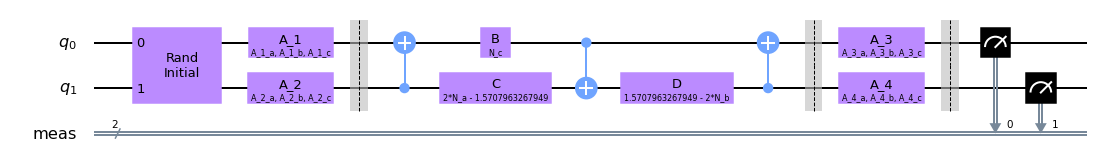

In [4]:
qc = ParamQuantumCircuit(2)
qc.draw()

Initial state for this circuit:


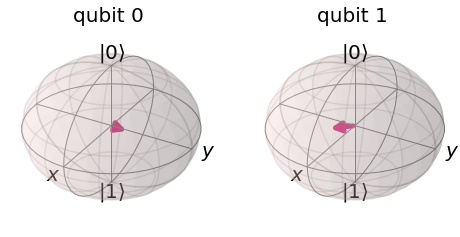

In [5]:
# initial state
print('Initial state for this circuit:')
plot_bloch_multivector(qc.initial_state)

In [6]:
def cost_func(params):
    return 1.0 - qc.run(params.tolist())

In [7]:
optimizer = POWELL(maxiter=5000, xtol=1e-8, tol=1e-8)
params = 2 * np.pi * np.random.rand(len(qc.params)) # omit global phase
result = optimizer.optimize(len(params), cost_func, 
                            variable_bounds=[(0, 2 * np.pi)] * len(params), 
                            initial_point=params)
print(f'Error: {result[1] * 100 : 0.3f}%')
print(f'Iteration: {result[2]}')

Error:  11.306%
Iteration: 1039


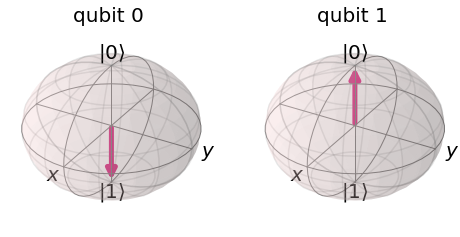

In [8]:
# one-shot sample (collapses randomly on each run)
output = qc.run_statevector(result[0])
plot_bloch_multivector(output)

In [9]:
# 1 shot
percents, shots = qc.run(result[0], False, shots = 1)
print(f'|01> : |10> = {percents.get("01",0):0.2f}% : {percents.get("10",0):0.2f}% out of {shots} shots')

|01> : |10> = 100.00% : 0.00% out of 1 shots


In [21]:
# 10 shots
percents, shots = qc.run(result[0], False, shots = 10)
print(f'|01> : |10> = {percents.get("01",0):0.2f}% : {percents.get("10",0):0.2f}% out of {shots} shots')

|01> : |10> = 40.98% : 41.43% out of 10 shots


In [15]:
# 100 shots
percents, shots = qc.run(result[0], False, shots = 100)
print(f'|01> : |10> = {percents.get("01",0):0.2f}% : {percents.get("10",0):0.2f}% out of {shots} shots')

|01> : |10> = 47.51% : 43.74% out of 100 shots


In [20]:
# 1000 shots
percents, shots = qc.run(result[0], False, shots = 1000)
print(f'|01> : |10> = {percents.get("01",0):0.2f}% : {percents.get("10",0):0.2f}% out of {shots} shots')

|01> : |10> = 53.66% : 39.35% out of 1000 shots
